<a href="https://colab.research.google.com/github/springboardmentor0-commits/CNN-Based-Music-Instrument-Recognition-System-/blob/Prasitha/InstruNet_Milestone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Check the file
dataset_path = '/content/drive/MyDrive/InstruNet_project/nsynth-test.jsonwav.tar.gz'

if os.path.exists(dataset_path):
    print("Success! The file is ready.")
else:
    print("Not found yet.")

Mounted at /content/drive
Success! The file is ready.


In [ ]:
# 1. Define the path again (just to be safe)
dataset_path = '/content/drive/MyDrive/InstruNet_project/nsynth-test.jsonwav.tar.gz'

# 2. Create a fast local folder
!mkdir -p /content/local_data

# 3. Unzip the file
!tar -xf "$dataset_path" -C /content/local_data

print("Unzip Complete! Files are ready in /content/local_data")

Unzip Complete! Files are ready in /content/local_data


In [ ]:
import librosa
import numpy as np
import os
import json
from tqdm import tqdm

# --- 1. CONFIGURATION (The Rules) ---
SAMPLE_RATE = 22050  # Standard AI Audio Speed
DURATION = 4.0       # Seconds per clip
SAMPLES_PER_TRACK = int(SAMPLE_RATE * DURATION)

# Paths (Using the data we just unzipped)
INPUT_DIR = '/content/local_data/nsynth-test/audio'
JSON_PATH = '/content/local_data/nsynth-test/examples.json'

OUTPUT_DIR = '/content/drive/MyDrive/InstruNet_project/Processed_Data'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- 2. LOAD LABELS ---
print("Loading file list...")
with open(JSON_PATH, 'r') as f:
    labels_map = json.load(f)

print(f" Found {len(labels_map)} audio files to process.")

# --- 3. THE PROCESSING LOOP ---
count = 0
errors = 0

for filename, metadata in tqdm(labels_map.items()):
    try:
        # A. Setup folders
        instrument_family = metadata['instrument_family_str']
        save_folder = os.path.join(OUTPUT_DIR, instrument_family)
        os.makedirs(save_folder, exist_ok=True)

        # B. Check if we already did this file (Skip if done)
        save_name = os.path.join(save_folder, filename + '.npy')
        if os.path.exists(save_name):
            continue

        # C. Load Audio (Cleaning Phase)
        file_path = os.path.join(INPUT_DIR, filename + '.wav')
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, mono=True)

        # D. Fix Duration (Cut or Pad to exactly 4s)
        if len(signal) > SAMPLES_PER_TRACK:
            signal = signal[:SAMPLES_PER_TRACK]
        else:
            padding = SAMPLES_PER_TRACK - len(signal)
            signal = np.pad(signal, (0, padding))

        # E. Create Spectrogram (Visualizing Phase)
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=SAMPLE_RATE, n_mels=128)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # F. Save to Drive
        np.save(save_name, log_mel_spectrogram)
        count += 1

    except Exception as e:
        errors += 1
        # print(f"Error on {filename}: {e}")

print(f"\n DONE! Processed {count} new files.")
print(f"Check your Drive folder: 'InstruNet_project/Processed_Data'")

Loading file list...
 Found 4096 audio files to process.


100%|██████████| 4096/4096 [00:14<00:00, 280.62it/s] 


 DONE! Processed 0 new files.
Check your Drive folder: 'InstruNet_project/Processed_Data'


Data Loaded!
Found 10 Unique Classes. Generating plot...


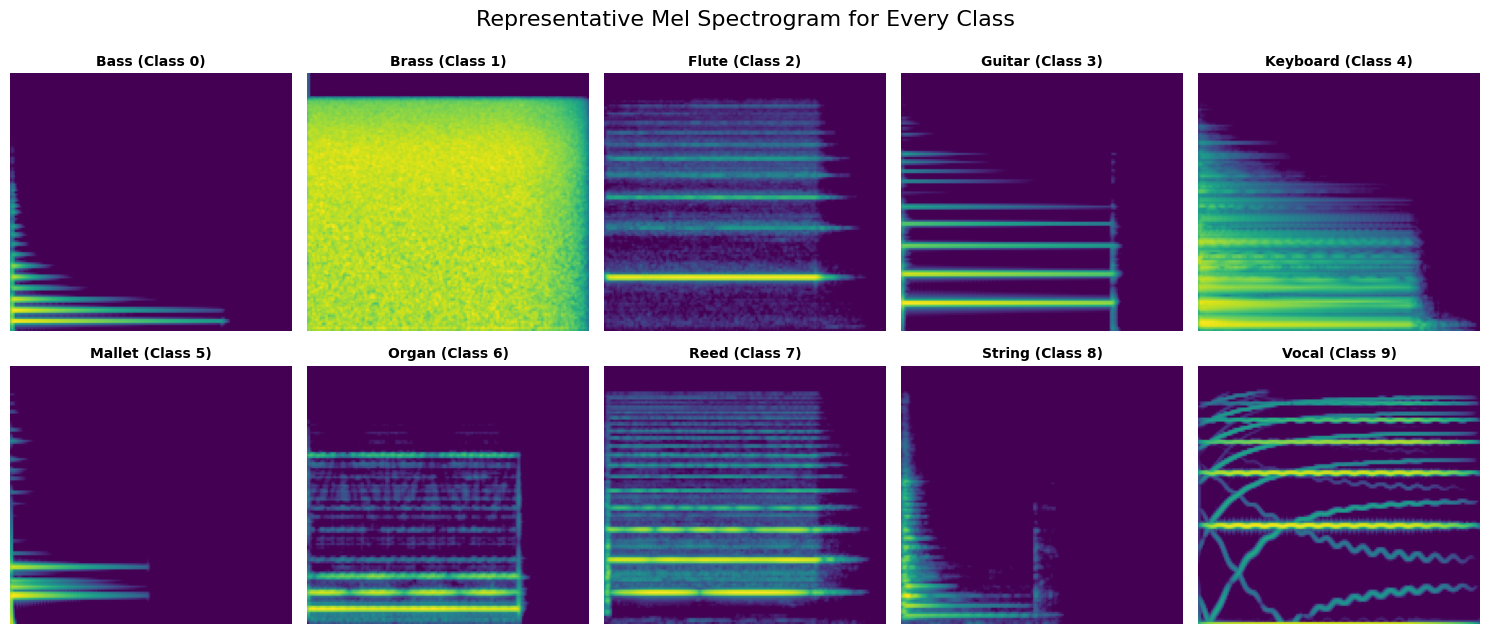

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- STEP 1: RELOAD THE DATA ---
# Make sure these paths match exactly where your files are in Drive!
X = np.load('/content/drive/MyDrive/InstruNet_project/X_balanced_500.npy')
y = np.load('/content/drive/MyDrive/InstruNet_project/y_balanced_500.npy')
print("Data Loaded!")

# --- STEP 2: DEFINE NAMES ---
class_names = {
    0: 'Bass', 1: 'Brass', 2: 'Flute', 3: 'Guitar', 4: 'Keyboard',
    5: 'Mallet', 6: 'Organ', 7: 'Reed', 8: 'String', 9: 'Vocal'
}

# --- STEP 3: PLOT THE GRID ---
unique_classes = np.unique(y)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

print(f"Found {len(unique_classes)} Unique Classes. Generating plot...")

for i, class_id in enumerate(unique_classes):
    # Find the index of the first sample that matches this class
    sample_index = np.where(y == class_id)[0][0]

    # Get the image
    img = X[sample_index]

    # Squeeze if necessary
    if img.ndim == 3:
        img = np.squeeze(img)

    # Plot
    ax = axes[i]
    ax.imshow(img, aspect='auto', origin='lower', cmap='viridis')

    # Add Title
    label_name = class_names.get(class_id, f"Class {class_id}")
    ax.set_title(f"{label_name} (Class {class_id})", fontsize=10, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.suptitle("Representative Mel Spectrogram for Every Class", fontsize=16, y=1.05)
plt.show()

Loading current uneven data...
Original Shape: (4096, 128, 173, 1)
Resampling every class to exactly 700 samples...
New Shape: (7000, 128, 173, 1)


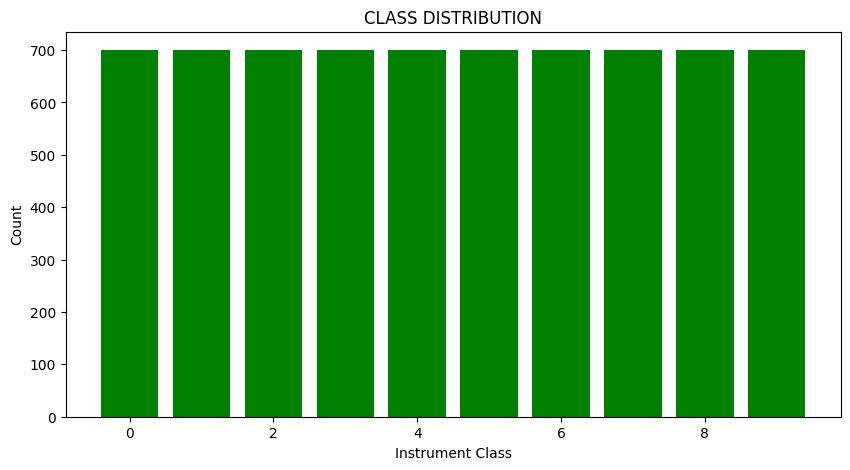

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Load your CURRENT uneven data
# (Make sure these paths match where your X.npy is right now)
print("Loading current uneven data...")
X = np.load('/content/drive/MyDrive/InstruNet_project/X.npy')
y = np.load('/content/drive/MyDrive/InstruNet_project/y.npy')

print(f"Original Shape: {X.shape}")
# Expected: (4096, 128, 173) or similar

# 2. DEFINE THE FIX (The Resampling Logic)
target_count = 700
X_balanced = []
y_balanced = []

classes = np.unique(y)
print(f"Resampling every class to exactly {target_count} samples...")

for cls in classes:
    # Find all samples that belong to this specific instrument
    indices = np.where(y == cls)[0]

    # THE MAGIC LINE:
    # If we have > 700, it picks 700 randomly (Under-sampling)
    # If we have < 700, it duplicates random ones until 700 (Over-sampling)
    selected_indices = np.random.choice(indices, target_count, replace=True)

    # Add these 700 samples to our new list
    X_balanced.append(X[selected_indices])
    y_balanced.append(y[selected_indices])

# 3. Stack them back into big arrays
X_final = np.concatenate(X_balanced)
y_final = np.concatenate(y_balanced)

# 4. Save the new "Fixed" files (Optional: so you don't have to run this again)
# np.save('/content/drive/MyDrive/InstruNet_project/X_balanced.npy', X_final)
# np.save('/content/drive/MyDrive/InstruNet_project/y_balanced.npy', y_final)

print(f"New Shape: {X_final.shape}")
# Expected: (5600, 128, 173)

# 5. SHOW THE PROOF (The Plot)
unique, counts = np.unique(y_final, return_counts=True)
plt.figure(figsize=(10, 5))
plt.bar(unique, counts, color='green')
plt.title("CLASS DISTRIBUTION")
plt.xlabel("Instrument Class")
plt.ylabel("Count")
plt.show()

MILESTONE 2

In [ ]:
# --- CELL 1: LOAD DATA ---
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# 1. Check GPU (To make sure training is fast)
print(f"Hardware Check: {tf.config.list_physical_devices('GPU')}")

# 2. Load the Files
print("Loading Data from Drive...")
# Make sure the path matches exactly where you uploaded the files!
X = np.load('/content/drive/MyDrive/InstruNet_project/X_balanced_500.npy')
y = np.load('/content/drive/MyDrive/InstruNet_project/y_balanced_500.npy')

print(f"Data Loaded! Found {len(X)} images.")

Hardware Check: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loading Data from Drive...
Data Loaded! Found 5000 images.


In [ ]:
# --- CELL 2: PREPARE & SPLIT ---
# 1. Normalize (Scale pixel values from 0-255 to 0-1)
X_norm = X / 255.0

# 2. Encode Labels (Convert "Bass" -> [1, 0, 0, ...])
y_encoded = to_categorical(y, num_classes=10)

# 3. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X_norm, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Data Ready:")
print(f"   - Training Samples: {X_train.shape[0]}")
print(f"   - Testing Samples:  {X_test.shape[0]}")

Data Ready:
   - Training Samples: 4000
   - Testing Samples:  1000


In [ ]:
# --- CELL 3: BUILD & TRAIN MODEL ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Define the Architecture
model = Sequential([
    # Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 173, 1)),
    MaxPooling2D((2, 2)),

    # Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Layer 3 (Deep learning layer)
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax') # 10 Output Neurons for 10 Instruments
])

# 2. Compile
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Show Summary Table
print(" Model Architecture:")
model.summary()

# 4. Train (The Learning Process)
print("\n Training Started (30 Epochs)...")
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 171, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 85, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 83, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 41, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 39, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 34048)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,358,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,452,234 (16.98 MB)

 Trainable params: 4,452,234 (16.98 MB)

 Non-trainable params: 0 (0.00 B)


 Training Started (30 Epochs)...
Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.1307 - loss: 2.2682 - val_accuracy: 0.3750 - val_loss: 1.8415
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.3302 - loss: 1.8241 - val_accuracy: 0.5030 - val_loss: 1.4171
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4353 - loss: 1.5118 - val_accuracy: 0.5730 - val_loss: 1.2026
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4928 - loss: 1.3219 - val_accuracy: 0.6460 - val_loss: 0.9576
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5650 - loss: 1.1475 - val_accuracy: 0.7100 - val_loss: 0.8284
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6218 - loss: 1.0045 - val_accuracy: 0.7440 - val_loss: 0.7281
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6736 - loss: 0.9032 - val_accuracy: 0.7600 - val_loss: 0.7044
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accurac

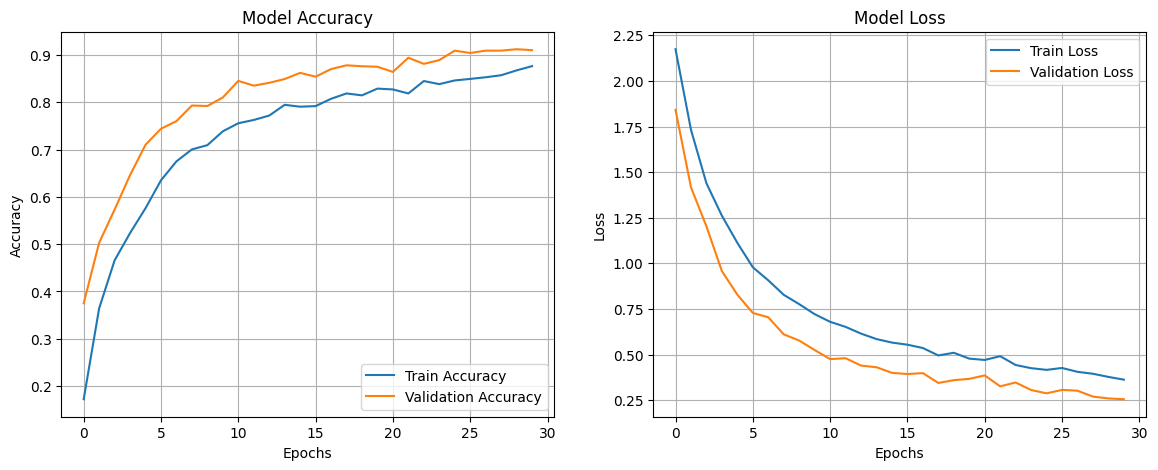

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


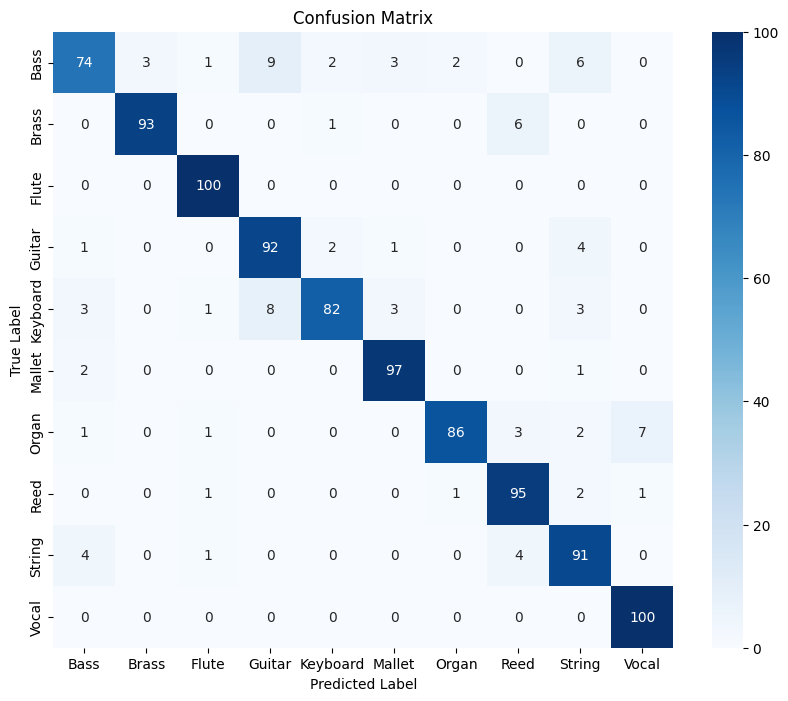


FINAL CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Bass       0.87      0.74      0.80       100
       Brass       0.97      0.93      0.95       100
       Flute       0.95      1.00      0.98       100
      Guitar       0.84      0.92      0.88       100
    Keyboard       0.94      0.82      0.88       100
      Mallet       0.93      0.97      0.95       100
       Organ       0.97      0.86      0.91       100
        Reed       0.88      0.95      0.91       100
      String       0.83      0.91      0.87       100
       Vocal       0.93      1.00      0.96       100

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [ ]:
# --- CELL 4: EVALUATION ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1. Plot Accuracy & Loss
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# 2. Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
class_names = ['Bass', 'Brass', 'Flute', 'Guitar', 'Keyboard', 'Mallet', 'Organ', 'Reed', 'String', 'Vocal']

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. Final Report
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# --- SAVE THE MODEL ---
import os

# 1. Define path (Save it in your Project Folder)
save_path = '/content/drive/MyDrive/InstruNet_project/InstruNet_Model_91acc.h5'

# 2. Save
model.save(save_path)

print(f"Model successfully saved to: {save_path}")

Model successfully saved to: /content/drive/MyDrive/InstruNet_project/InstruNet_Model_91acc.h5
